# HW 2: Clustering and Topic Models [100 points]

Name: Alex Caico

Andrew ID: acaico

Collaborators (if none, say "none"; do *not* leave this blank): Colton Mouritsen, Ben Turner
https://stackoverflow.com/questions/31107945/how-to-perform-prediction-with-lda-linear-discriminant-in-scikit-learn

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). Data is provided in the `enron` data directory, with one file per email. The data set includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam. 

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the makeWordList function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
######################### Write your code here #########################

import glob
files = glob.glob('./data/enron/*.txt')
                  
email_list = []                 
for file in files:
    email_list.append(makeWordList(file))

print("Number of emails:", len(email_list))


Number of emails: 5171


### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [3]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8,
                             min_df=50, 
                             stop_words='english')

X = vectorizer.fit_transform(email_list)

In [4]:
print("Number of unique words", len(vectorizer.vocabulary_))
print("Matrix Shape", X.shape)

Number of unique words 1680
Matrix Shape (5171, 1680)


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix X using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [5]:
########################################################################
######################### Write your code here #########################
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=3, max_iter=200, random_state=0)
gmm.fit(X.toarray())

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [6]:
import matplotlib.pyplot as plt
gmm_cluster_assignments = gmm.predict(X.toarray())

In [7]:
print("Cluster 1 size: ", len(X.toarray()[gmm_cluster_assignments == 0]))
print("Cluster 2 size: ", len(X.toarray()[gmm_cluster_assignments == 1]))
print("Cluster 3 size: ", len(X.toarray()[gmm_cluster_assignments == 2]))

Cluster 1 size:  363
Cluster 2 size:  1786
Cluster 3 size:  3022


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes four parameters:
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [8]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

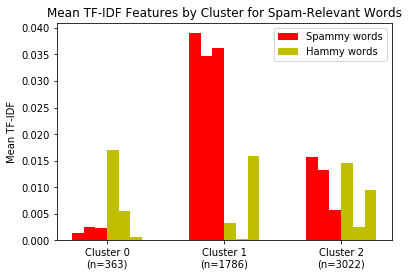

In [9]:
########################################################################
######################### Write your code here #########################
########################################################################

spam_indices = [vectorizer.vocabulary_['click'], vectorizer.vocabulary_['free'], vectorizer.vocabulary_['www']]
ham_indices = [vectorizer.vocabulary_['offer'], vectorizer.vocabulary_['analysis'], vectorizer.vocabulary_['report']]

plot_spam_words_by_cluster(gmm_cluster_assignments, 3, spam_indices, ham_indices)


### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

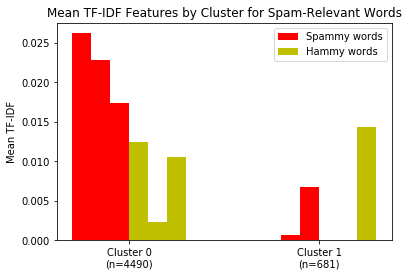

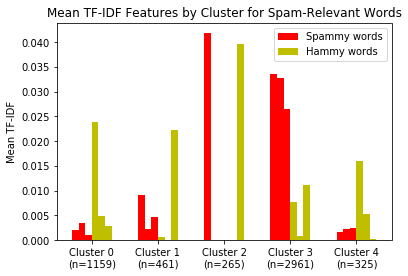

In [10]:
components = [2,5]
for component in components:
    gmm = mixture.GaussianMixture(n_components=component, max_iter=100, random_state=0)
    gmm.fit(X.toarray())
    gmm_cluster_assignments = gmm.predict(X.toarray())
    spam_indices = [vectorizer.vocabulary_['click'], vectorizer.vocabulary_['free'], vectorizer.vocabulary_['www']]
    ham_indices = [vectorizer.vocabulary_['offer'], vectorizer.vocabulary_['analysis'], vectorizer.vocabulary_['report']]
    plot_spam_words_by_cluster(gmm_cluster_assignments, component, spam_indices, ham_indices)

*** WRITE YOUR ANSWER HERE IN TEXT ***

When running with 3 clusters, some of the clusters seems to represent spam vs. ham emails. Cluster1 shows that the spam words I've chosen appear very frequently within that cluster, meaing this cluster is for spam email. Cluster 0 has barely any spam words, but does have more business words, so this seems that cluster are ham emails. Cluster 2 has about the same frequency for the spam and ham words I tried, so I cannot tell if this cluster if spam or ham mail. 

When running the GMM again with with 2 and 5 clusters the results change. There is still some interpretable clusters that can be considered as clusters for spam and ham email. With 2 clusters, cluster 0 is most likely to be spam and cluster 1 is ham. With 5 clusters, cluster 3 seems to represent spam emails. The other clusters are not as definitive. 

Using 3 clusters gave the most distinct clusters that can be used to separate spam vs ham emails. 

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [12]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [13]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [14]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [15]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
df_app_names= df["App"]#create to use app names
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X1 = df_perms.as_matrix()
X_app_names = df_app_names.as_matrix()
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM


C:\Users\ajcai\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\ajcai\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


### Part C: Downweight "stop-words" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [16]:
########################################################################
######################### Write your code here #########################
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(norm='l2')
X_transformed = transformer.fit_transform(X1)

print("App by permission matrix shape:", X_transformed.shape)

App by permission matrix shape: (180295, 173)


### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [17]:
%%time
########################################################################
######################### Write your code here #########################
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=10, max_iter = 10, learning_decay= 0.7, learning_offset= 10, learning_method='online', random_state=20, n_jobs=-1)
LDA.fit(X_transformed)

Wall time: 3min 38s


In [18]:
print("Components by permissions matrix shape:", LDA.components_.shape)

Components by permissions matrix shape: (10, 173)


Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [19]:
########################################################################
######################### Write your code here #########################
########################################################################

topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in LDA.components_])

print(type(topic_word_distributions))
print(topic_word_distributions.size)
print(topic_word_distributions.shape)
print(len(permission_columns))


<class 'numpy.ndarray'>
1730
(10, 173)
173


In [20]:
num_top_words = 10

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

for topic_idx in range(10):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(permission_columns[word_idx], ':', "{:1.6f}".format(topic_word_distributions[topic_idx, word_idx]))
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
Storage : modify/delete USB storage contents modify/delete SD card contents (D) : 0.547589
Network communication : full Internet access (D) : 0.210895
Network communication : view network state (S) : 0.126433
Hardware controls : record audio (D) : 0.105671
Default : delete other applications' caches (S) : 0.007547
System tools : send package removed broadcast (S) : 0.000846
Default : read frame buffer (S) : 0.000006
Default : delete other applications' data (S) : 0.000006
Default : access SurfaceFlinger (S) : 0.000006
Hardware controls : control vibrator (S) : 0.000006

[Topic 1]
Hardware controls : take pictures and videos (D) : 0.134684
Services that cost you money : directly call phone numbers (D) : 0.131066
Your location : fine (GPS) location (D) : 0.102678
Network communication : full Internet access (D) : 0.081951
Your location : coarse (network-based) location (D) : 0.081762
Storage : mo

*** WRITE YOUR ANSWER HERE IN TEXT ***

There are some topics that seem to have similarly grouped features and corresponse to meaningfull app purchases. Topic 3 seems to be corresponding to communication type apps, since the permission all the app to directly call phone numbers, send SMS message, read contact data, and receive SMS. Topic 2 has permissions related to GPS locations, so location based apps may be in this topic. Some topics though don't seem to permissions that make sense together. This may be because the number of clusters we have chosen. We could change the number of topics and check the cluster coherence to see how it changes to figure out the optimal number of topics. 

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [21]:
########################################################################
######################### Write your code here #########################

#Filter on apps with more than 100,000 ratings
high_app_ratings = app_ratings > 100000
app_ratings_3k = app_ratings > 3000 #Filters approx. 2500 apps, use for plotting scatter plot

#Filter app x feature matrix by top rated apps
X_high_ratings = X1[high_app_ratings]
top_app_names = X_app_names[high_app_ratings]
X_app_ratings_3k = X1[app_ratings_3k]

print("Number of apps > 100,000 Ratings: ", len(X_high_ratings))
print("Number of apps > 3,000 Ratings  : ", len(X_app_ratings_3k))

Number of apps > 100,000 Ratings:  95
Number of apps > 3,000 Ratings  :  2503


In [22]:
#Transpose to do matrix dot product
topic_word_transpose = topic_word_distributions.transpose()

#Perform dot product to determine probability of an app being within each topic
X_all_app_topic = np.dot(X1, topic_word_transpose) #All apps
X_app_topic = np.dot(X_high_ratings, topic_word_transpose) #Top apps, ratings > 100K
X_3k_app_topic = np.dot(X_app_ratings_3k, topic_word_transpose) #Ratings > 3K

print('[All apps]')
print("App by Permissions matrix shape             :", X1.shape)
print("Topic by Permission Transposed matrix shape :", topic_word_transpose.shape)
print("App by Topic dot product result matrix shape:", X_all_app_topic.shape)

print('\n[Top apps with > 100,000 ratings]')
print("App by Permissions matrix shape             :", X_high_ratings.shape)
print("Topic by Permission Transposed matrix shape :", topic_word_transpose.shape)
print("App by Topic dot product result matrix shape:", X_app_topic.shape)



[All apps]
App by Permissions matrix shape             : (180295, 173)
Topic by Permission Transposed matrix shape : (173, 10)
App by Topic dot product result matrix shape: (180295, 10)

[Top apps with > 100,000 ratings]
App by Permissions matrix shape             : (95, 173)
Topic by Permission Transposed matrix shape : (173, 10)
App by Topic dot product result matrix shape: (95, 10)


In [23]:
## determine top 3 apps most probable to be within each topic 

for topic_idx in range(topic_word_transpose.shape[1]):
    app_scores = []
    app_score_dict = {}
    
    print('\n[Topic ', topic_idx, ']', sep='')
    
    for app_idx in range(len(X_high_ratings)):
        app_score = X_app_topic[app_idx, topic_idx]
        app_scores.append(app_score)
        app_score_dict[top_app_names[app_idx]] = app_score 
    
    #Sort dictionary
    from operator import itemgetter
    sorted_app_count = sorted(app_score_dict.items(), 
                           reverse = True, 
                           key=itemgetter(1))
    
    rank = 1
    for app, score in sorted_app_count[:3]:
        print("Rank", rank, "Name: ", app, "Score: ", "{:1.6f}".format(score))
        rank +=1


[Topic 0]
Rank 1 Name:  Skype Score:  0.990734
Rank 2 Name:  WhatsApp Messenger Score:  0.990728
Rank 3 Name:  Tango Voice & Video Calls Score:  0.990722

[Topic 1]
Rank 1 Name:  Skype Score:  0.790021
Rank 2 Name:  WhatsApp Messenger Score:  0.763052
Rank 3 Name:  Google Maps Score:  0.714817

[Topic 2]
Rank 1 Name:  Lookout Security & Antivirus Score:  0.997854
Rank 2 Name:  WhatsApp Messenger Score:  0.997836
Rank 3 Name:  Google Maps Score:  0.997828

[Topic 3]
Rank 1 Name:  Skype Score:  0.997263
Rank 2 Name:  WhatsApp Messenger Score:  0.997254
Rank 3 Name:  Tango Voice & Video Calls Score:  0.997245

[Topic 4]
Rank 1 Name:  Lookout Security & Antivirus Score:  0.998949
Rank 2 Name:  Antivirus Free Score:  0.998944
Rank 3 Name:  Dolphin Browser??? HD Score:  0.927341

[Topic 5]
Rank 1 Name:  Handcent SMS Score:  0.705198
Rank 2 Name:  Dolphin Browser??? HD Score:  0.681475
Rank 3 Name:  Dolphin Browser™ HD Score:  0.681475

[Topic 6]
Rank 1 Name:  Lookout Security & Antivirus Sc

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [24]:
######################### Write your code here #########################
from sklearn.manifold import TSNE

#Using list of top 2500 apps for plotting

#Create Topic Labels for colors
topic_labels = []
for app_idx in range (X_3k_app_topic.shape[0]):
    topics_sorted = []
    topics_sorted = np.argsort(X_3k_app_topic[app_idx])[::-1]
    topic_labels.append(topics_sorted[0])

print("Topic    Count of Apps")
for topic in range(10):
    print(topic, "      ", topic_labels.count(topic))

print("Total   ",len(topic_labels))

Topic    Count of Apps
0        171
1        11
2        48
3        35
4        76
5        8
6        9
7        1927
8        59
9        159
Total    2503


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 2503 samples in 0.006s...
[t-SNE] Computed neighbors for 2503 samples in 0.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2503
[t-SNE] Computed conditional probabilities for sample 2000 / 2503
[t-SNE] Computed conditional probabilities for sample 2503 / 2503
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.065826
[t-SNE] KL divergence after 1000 iterations: 0.286503


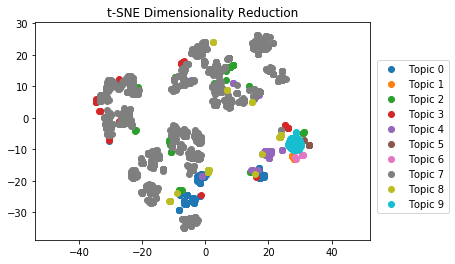

Wall time: 25.7 s


In [25]:
%%time
#Run tSNE and plot graph
tsne = TSNE(n_components=2, perplexity=80, learning_rate=300, init='pca', angle = 0.99, verbose = 1, random_state=0)
X_app_topic_tsne = tsne.fit_transform(X_3k_app_topic)

for topic in range(10):
    plt.scatter(X_app_topic_tsne[np.array(topic_labels)==topic][:, 0]
              , X_app_topic_tsne[np.array(topic_labels)==topic][:, 1], 
                label=('Topic ' + str(topic)))

plt.legend(loc=4, bbox_to_anchor=(1.25, .1))
plt.title("t-SNE Dimensionality Reduction")
plt.axis('equal')
plt.show()

The t-SNE reduced dimensions does contain a clustering structure. Topic 7 had a majority of the apps, so that topic appears in many of the clusters seen in t-SNE.

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://goo.gl/forms/qi1acwKwxSfNJfjt1